In [34]:
import math
import os
import json
import uuid
import re
import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram, melfilterbank, plot_waveform
import IPython.display as Ipd
from torchsummary import summary

In [4]:
def determine_is_stridor(path):
    """
    Determine if the path should be marked as stridor based on the parent folder.
    """
    for part in path.split(os.sep):
        if part.upper() in ["CONTROL", "CONTROLS"]:
            return False
    return True

def generate_recording_objects(root_path, output_json):
    recordings = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(root_path):
        # Check if there are wav files in the current directory
        wav_files = [file for file in files if file.endswith('.wav')]
        if wav_files:
            # Get the parent folder name
            parent_folder = os.path.basename(root)
            # Determine the isStridor value
            is_stridor = determine_is_stridor(root)
            
            for wav_file in wav_files:
                # Generate a unique ID for each player-session-recording combination
                uid = str(uuid.uuid4())
                # Extract the recording label (base name without extension)
                recording_label = os.path.splitext(wav_file)[0]
                # Create the entry for the current recording
                entry = {
                    "uid": uid,
                    "name": parent_folder,
                    "recording": os.path.join(root, wav_file),  # Include the full path
                    "recording_label": recording_label,
                    "isStridor": is_stridor
                }
                recordings.append(entry)
                
    return recordings

In [5]:
def filter_recordings_by_label(data, label_prefix):
    """
    Filter recordings to only include those with recording_label starting with the specified prefix.
    Exclude specific labels when the prefix is 'FIMO'.
    """
    exclude_labels = {"FIMO": ["FIMOcricoid", "FIMOthyroid", "FIMOC", "FIMOT"]}

    filtered_data = []
    for recording in data:
        if recording['recording_label'].startswith(label_prefix):
            if label_prefix == "FIMO" and recording['recording_label'] in exclude_labels["FIMO"]:
                continue
            filtered_data.append(recording)

    return filtered_data

In [6]:
# Usage
root_path = 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files'  # Replace with the actual path to your folders
stridor_labels = 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Stridor_Labels.csv' # Replace with stridor labels csv
output_json = 'output_individual.json'  # Replace with the desired output JSON file name
data = generate_recording_objects(root_path, output_json)

print(f"rcordings: {data}")

rcordings: [{'uid': '7293dc8c-b9f1-4513-a2e0-9aca9a48de8f', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMCcricoid.wav', 'recording_label': 'FEMCcricoid', 'isStridor': True}, {'uid': '7c62a639-a059-4155-b773-33fd70b489e0', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMOcricoid.wav', 'recording_label': 'FEMOcricoid', 'isStridor': True}, {'uid': '0d0f342c-ba95-4ae9-88d9-76fd8d9ef90e', 'name': 'Patient 1', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 1\\FEMOthyroid.wav', 'recording_label': 'FEMOthyroid', 'isStridor': True}, {'uid': 'a1c064d7-dd32-4ed6-bc5d-4353bdfb8564', 'name': 'Patient 1'

In [7]:
# Filter the data to only include recordings with recording_label starting with "FIMO"
filtered_data = filter_recordings_by_label(data, "FIMO")

print(f"filtered recordings: {filtered_data}")

filtered recordings: [{'uid': '6dccc484-8845-4972-b558-a53ec8a45feb', 'name': 'Patient 2', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 2\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': 'fabc8f84-59f4-4c3f-a850-4e3ac17905d4', 'name': 'Patient 3', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 3\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': 'cf06fdf4-1ec8-4040-8c14-6d8a3ddc83f1', 'name': 'Patient 4', 'recording': 'c:\\Users\\utska\\OneDrive\\Med School\\Research\\Voice AI\\STRIDOR FULL ANON\\Data files\\OLD methods\\INITIAL (Avid, mostly asynchronous)\\Patient 4\\FIMO12inch.wav', 'recording_label': 'FIMO12inch', 'isStridor': True}, {'uid': '4eda5db1-8631-4eac-ac98-b7778ff4a4da', 'name': 'Patien

In [8]:
# Combine and merge phonatory vs non-phonatory information with original dataset
df = pd.DataFrame(filtered_data)
stridor_df = pd.read_csv(stridor_labels)
stridor_df['isStridor'] = stridor_df['Status'].apply(lambda x: False if 'No-Stridor' in x else True)
stridor_df = stridor_df.rename(columns={'Name': 'name'})
merged = pd.merge(df, stridor_df, on='name', how='left')
merged = merged.rename(columns={'isStridor_y': 'isStridor'})
merged['isStridor'].fillna(merged['isStridor_x'], inplace=True)
merged = merged.drop(columns = ['isStridor_x'])
merged.loc[~merged['name'].str.contains('Patient'), 'Status'] = 'No-Stridor'
num_pts = len(merged.loc[merged['name'].str.contains('Patient')]['name'].unique())
num_ctrls = len(merged.loc[~merged['name'].str.contains('Patient')]['name'].unique())
print('Number of Patients:', num_pts, ' Number of Controls:',  num_ctrls)
merged.loc[merged['Status'].isna() == False].drop(columns = 'recording')

Number of Patients: 38  Number of Controls: 20


,uid,name,recording_label,Status,isStridor
0,6dccc484-8845-4972-b558-a53ec8a45feb,Patient 2,FIMO12inch,Non-Phonatory,True
1,fabc8f84-59f4-4c3f-a850-4e3ac17905d4,Patient 3,FIMO12inch,Phonatory,True
2,cf06fdf4-1ec8-4040-8c14-6d8a3ddc83f1,Patient 4,FIMO12inch,Non-Phonatory,True
3,4eda5db1-8631-4eac-ac98-b7778ff4a4da,Patient 6,FIMO12inch,Phonatory,True
4,897a3096-513b-4ef7-b4f0-db05730a78e2,Patient 7,FIMO12inch,Phonatory,True
...,...,...,...,...,...
105,547d6a7c-7b25-4734-b85b-5f365b99b231,Patient 40,FIMOiPad,Phonatory,True
106,32eddf42-d81b-499d-a6d6-b007433d3834,Patient 41,FIMOAvid,Non-Phonatory,True
107,51b6c4ce-df3e-4bc3-82ef-f4633feeccb8,Patient 41,FIMOiPad,Non-Phonatory,True
108,4c859bbd-9fad-48b5-9b6b-4687338ae2f0,Patient 42,FIMOAvid,Non-Phonatory,True


In [45]:
class MySpecgramDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, segment_size=5):
        self.dataframe = dataframe
        self.segment_size = segment_size
        
        # Ensure the DataFrame has the necessary columns
        required_columns = ['uid', 'recording', 'recording_label', 'isStridor']
        for col in required_columns:
            if col not in dataframe.columns:
                raise ValueError(f"DataFrame is missing required column: {col}")

        # Extract necessary information from the DataFrame
        self.audio_files = dataframe['recording'].tolist()
        self.labels = dataframe['isStridor'].tolist()
        self.uids = dataframe['uid'].tolist()
        self.recording_labels = dataframe['recording_label'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        recording_label = self.recording_labels[idx]

        try:
            audio = Audio.from_file(self.audio_files[idx])
            audio = audio.to_16khz()
            # get middle K seconds if audio is too long, pad with zeros if it is too short
            if audio.signal.size(0) > self.segment_size*16000:
                d = (audio.signal.size(0)-self.segment_size*16000)//2
                audio.signal = audio.signal[d:d+self.segment_size*16000]
            else:
                audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)
                
            win_length = 50
            hop_length = 1
            nfft = int(win_length * 16)
            features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
            features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))
            #features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
            mel_specgram = melfilterbank(features_specgram)

        except Exception as e:
            print(f"Error loading {audio_file}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Convert the label to a tensor
        label = torch.tensor(label, dtype=torch.float32)

        return {'uid': uid, 'signal': audio.signal, 'specgram' : features_specgram, 'isStridor': label, 'recording_label': recording_label}

dataset: <__main__.MySpecgramDataset object at 0x00000254000D6630>
['FIMO12inch', 'FIMOAvid', 'FIMOAvid', 'FIMOavid', 'FIMOiPad', 'FIMOiPad', 'FIMOiPad', 'FIMOiPad'] tensor([1., 0., 0., 0., 0., 1., 1., 1.])


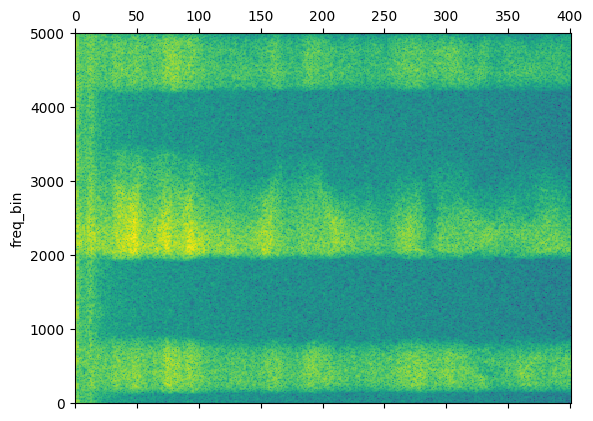

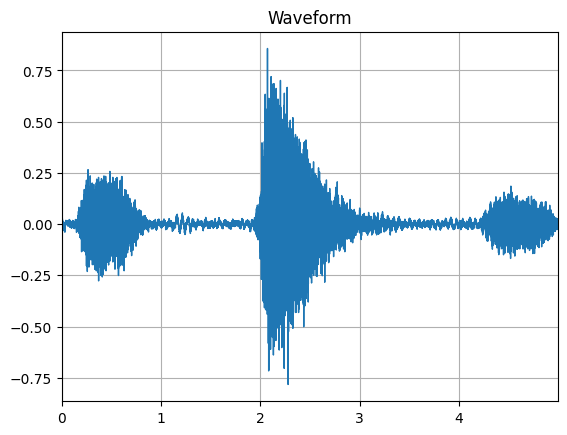

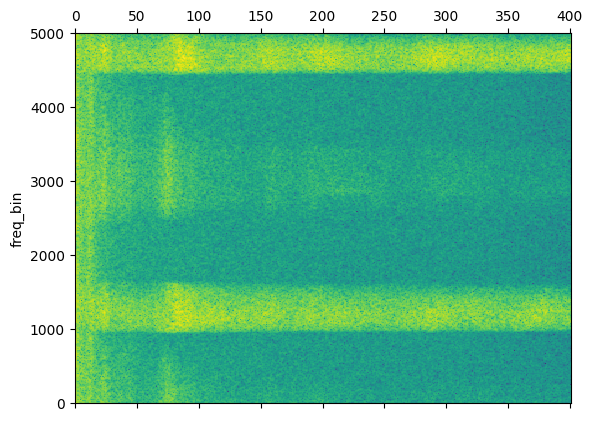

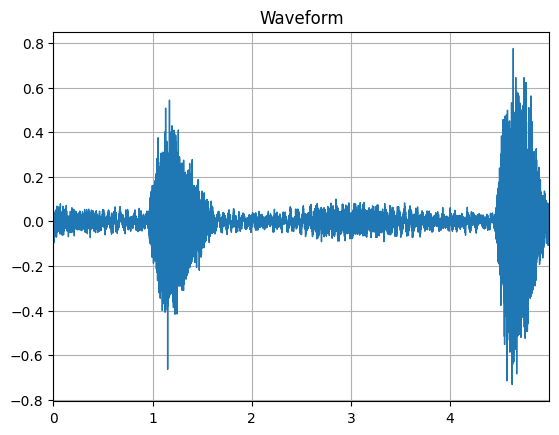

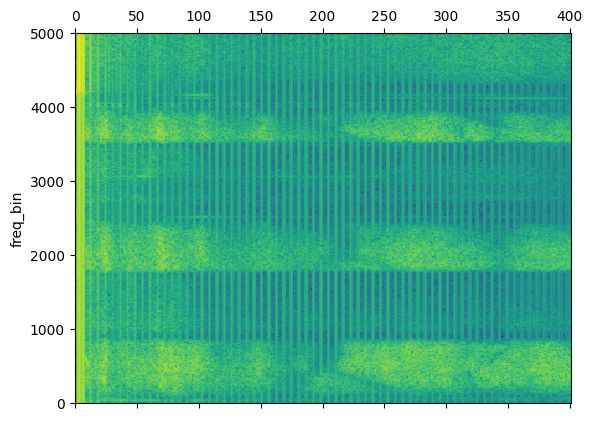

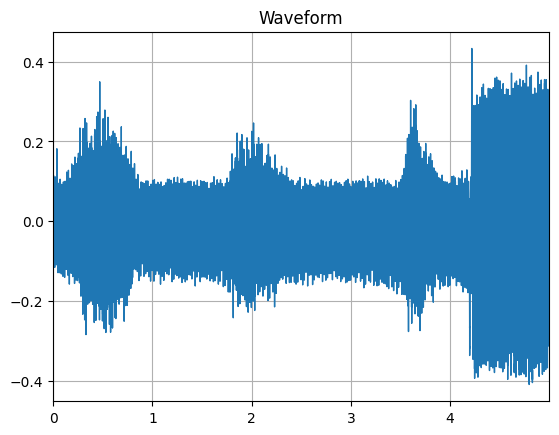

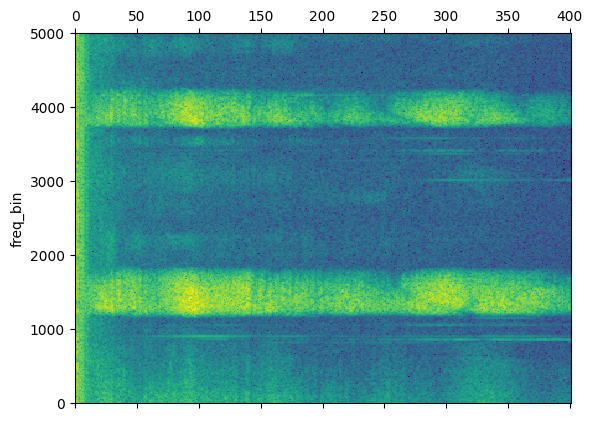

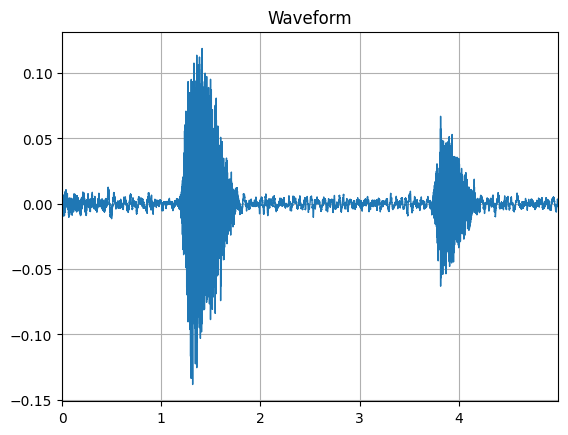

In [46]:
dataset = MySpecgramDataset(merged)
print(f"dataset: {dataset}")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching and shuffling
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Example: Iterate through the train DataLoader
for batch in train_dataloader:
    #batch['mel'] = melfilterbank(batch['signal'])
    print(batch['recording_label'], batch['isStridor'])
    for i in range(1,5):
        plot_spectrogram(batch['specgram'][i])
        plot_waveform(batch['signal'][i], 16000, title="Waveform", ax=None)
    #plot_spectrogram(batch['mel'][0])
    #print("shape:", batch['signal'].shape)
    break

In [93]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(torch.nn.Module):
    def __init__(self, ntoken, nout, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = torch.nn.Linear(ntoken, ninp)
        self.ninp = ninp
        self.decoder = torch.nn.Linear(ninp, nout)

    def forward(self, src):
        src = self.encoder(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

In [94]:
transformer = TransformerModel(20, 1, 256, 4, 512, 2, 0.1)
#for batch in val_dataloader:
    #print(batch['signal'][0].shape)
# _ = summary(transformer, (257, 301))

In [95]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['isStridor'][i]
			else:
				acc += 1.0-batch['isStridor'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 10
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	transformer.train()
	
	closs = []
	for batch in train_dataloader:
		optimizer.zero_grad()
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['isStridor'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(transformer, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(transformer, train_dataloader), val_acc))

	if val_acc >= best_val_acc:
		best_val_acc = val_acc
		torch.save(transformer.state_dict(), './my_transformer_model.pth')
		print('Saved!')

Epoch:1 TrainLoss:0.7138 TrainACC:0.5260 ValACC:0.4861
Saved!
Epoch:2 TrainLoss:0.7016 TrainACC:0.4740 ValACC:0.5139
Saved!
Epoch:3 TrainLoss:0.7083 TrainACC:0.4740 ValACC:0.5139
Saved!
Epoch:4 TrainLoss:0.7002 TrainACC:0.5712 ValACC:0.5139
Saved!
Epoch:5 TrainLoss:0.6933 TrainACC:0.5538 ValACC:0.3750
Epoch:6 TrainLoss:0.6931 TrainACC:0.5278 ValACC:0.4861
Epoch:7 TrainLoss:0.6924 TrainACC:0.5330 ValACC:0.4861
Epoch:8 TrainLoss:0.6889 TrainACC:0.5590 ValACC:0.5139
Saved!
Epoch:9 TrainLoss:0.6949 TrainACC:0.5243 ValACC:0.4861
Epoch:10 TrainLoss:0.6888 TrainACC:0.5243 ValACC:0.5417
Saved!


In [96]:
transformer.load_state_dict(torch.load('./my_transformer_model.pth'))
test_acc = eval(transformer, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.4658


In [34]:
transformer.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	with torch.no_grad():
		outputs = torch.mean(torch.nn.functional.sigmoid(transformer(batch['signal'])),dim=1).squeeze(1)
	for i in range(len(batch['signal'])):
		total[int(batch['isStridor'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['isStridor'][i])] += batch['isStridor'][i]
		else:
			acc[int(batch['isStridor'][i])] += 1.0-batch['isStridor'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

Class #0 (25) ACC:0.0400 Class #1 (48) ACC:0.9583
